In [1]:
from __future__ import division, print_function
import time
import torch.utils.data
from torchvision import transforms, datasets
import argparse
import matplotlib

import torchvision

import matplotlib.pyplot as plt

from __future__ import division
import numpy as np
import torch

import torch.nn.functional as F
import torch.nn as nn
import copy

from __future__ import print_function, division
import torch
from torch.autograd import Variable
from PIL import Image
import torch.utils.data as data
import numpy as np
import os
import sys
try:
    import cPickle as pickle
except:
    import pickle
    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import scipy.ndimage as ndim
import matplotlib.colors as mcolors
import pandas as pd
import time
import torch.utils.data
from torchvision import transforms, datasets
import torchvision
import argparse
import matplotlib
from src.Stochastic_Gradient_Langevin_Dynamics.model import *
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import Optimizer

import collections
import h5py, sys
import gzip
import os
import math
import numpy as np
import pandas as pd

try:
    import cPickle as pickle
except:
    import pickle


import time
import torch.utils.data
from torchvision import transforms, datasets
import torchvision
import matplotlib

import time
import torch.utils.data
from torchvision import transforms, datasets
import argparse
import matplotlib
from src.Bayes_By_Backprop.model import *
from src.Bayes_By_Backprop_Local_Reparametrization.model import *
import torchvision

import matplotlib.pyplot as plt

In [2]:
# image_trans_size_SGLD = 64
# batch_size_SGLD = 20
# nb_epochs_SGLD = 100
# lr_SGLD = 0.00001
# prior_sig_SGLD = 0.1
# models_dir_SGLD = 'models_SGLD_COVID150'
# results_dir_SGLD = 'results_SGLD_COVID150'
# pSGLD_SGLD = False
# save_data_SGLD = True
# n_samples = 90
# sample_freq = 2
# burn_in = 20

image_trans_size = 128
batch_size = 20
nb_epochs = 100

pSGLD = False
save_data = True
n_samples = 10

sample_freq = 2
burn_in = 20



prior_sig = 0.1
# Where to save models weights
models_dir = 'models_BBB_COVID150'
# Where to save plots and error, accuracy vectors
results_dir = 'results_BBB_COVID150'

lr = 0.00001

model= 'Gaussian_prior'
nsamples = int(n_samples)
Nsamples = 20


save_every = int(nb_epochs/20)  
# We sample every 2 epochs as I have found samples to be correlated after only 1
num_workers = 4
nhid = 1200

transform_covid19 = transforms.Compose([
    transforms.Resize(image_trans_size),
    transforms.CenterCrop(image_trans_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=1)
])

In [3]:



def isotropic_gauss_loglike(x, mu, sigma, do_sum=True):
    cte_term = -(0.5) * np.log(2 * np.pi)
    det_sig_term = -torch.log(sigma)
    inner = (x - mu) / sigma
    dist_term = -(0.5) * (inner ** 2)

    if do_sum:
        out = (cte_term + det_sig_term + dist_term).sum()  # sum over all weights
    else:
        out = (cte_term + det_sig_term + dist_term)
    return out


class laplace_prior(object):
    def __init__(self, mu, b):
        self.mu = mu
        self.b = b

    def loglike(self, x, do_sum=True):
        if do_sum:
            return (-np.log(2 * self.b) - torch.abs(x - self.mu) / self.b).sum()
        else:
            return (-np.log(2 * self.b) - torch.abs(x - self.mu) / self.b)


class isotropic_gauss_prior(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

        self.cte_term = -(0.5) * np.log(2 * np.pi)
        self.det_sig_term = -np.log(self.sigma)

    def loglike(self, x, do_sum=True):

        dist_term = -(0.5) * ((x - self.mu) / self.sigma) ** 2
        if do_sum:
            return (self.cte_term + self.det_sig_term + dist_term).sum()
        else:
            return (self.cte_term + self.det_sig_term + dist_term)


class spike_slab_2GMM(object):
    def __init__(self, mu1, mu2, sigma1, sigma2, pi):
        self.N1 = isotropic_gauss_prior(mu1, sigma1)
        self.N2 = isotropic_gauss_prior(mu2, sigma2)

        self.pi1 = pi
        self.pi2 = (1 - pi)

    def loglike(self, x):
        N1_ll = self.N1.loglike(x)
        N2_ll = self.N2.loglike(x)

        # Numerical stability trick -> unnormalising logprobs will underflow otherwise
        max_loglike = torch.max(N1_ll, N2_ll)
        normalised_like = self.pi1 * torch.exp(N1_ll - max_loglike) + self.pi2 * torch.exp(N2_ll - max_loglike)
        loglike = torch.log(normalised_like) + max_loglike

        return loglike

In [4]:



class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

In [5]:



def load_object(filename):
    with open(filename, 'rb') as input:
        return pickle.load(input)


def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)


suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']


def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes) - 1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])


def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return ((nb_samples + (-nb_samples % batch_size)) / batch_size)  # roundup division
    else:
        return nb_samples / batch_size


def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))
    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]


def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out


def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()


def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)


class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

class DatafeedImage(data.Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)


### functions for BNN with gauss output: ###

def diagonal_gauss_loglike(x, mu, sigma):
    # note that we can just treat each dim as isotropic and then do sum
    cte_term = -(0.5)*np.log(2*np.pi)
    det_sig_term = -torch.log(sigma)
    inner = (x - mu)/sigma
    dist_term = -(0.5)*(inner**2)
    log_px = (cte_term + det_sig_term + dist_term).sum(dim=1, keepdim=False)
    return log_px

def get_rms(mu, y, y_means, y_stds):
    x_un = mu * y_stds + y_means
    y_un = y * y_stds + y_means
    return torch.sqrt(((x_un - y_un)**2).sum() / y.shape[0])


def get_loglike(mu, sigma, y, y_means, y_stds):
    mu_un = mu * y_stds + y_means
    y_un = y * y_stds + y_means
    sigma_un = sigma * y_stds
    ll = diagonal_gauss_loglike(y_un, mu_un, sigma_un)
    return ll.mean(dim=0)


In [6]:


def sample_weights(W_mu, b_mu, W_p, b_p):
    """Quick method for sampling weights and exporting weights"""
    eps_W = W_mu.data.new(W_mu.size()).normal_()
    # sample parameters
    std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)
    W = W_mu + 1 * std_w * eps_W

    if b_mu is not None:
        std_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)
        eps_b = b_mu.data.new(b_mu.size()).normal_()
        b = b_mu + 1 * std_b * eps_b
    else:
        b = None

    return W, b


class BayesLinear_Normalq(nn.Module):
    """Linear Layer where weights are sampled from a fully factorised Normal with learnable parameters. The likelihood
     of the weight samples under the prior and the approximate posterior are returned with each forward pass in order
     to estimate the KL term in the ELBO.
    """
    def __init__(self, n_in, n_out, prior_class):
        super(BayesLinear_Normalq, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.prior = prior_class

        # Learnable parameters -> Initialisation is set empirically.
        self.W_mu = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-0.1, 0.1))
        self.W_p = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-3, -2))

        self.b_mu = nn.Parameter(torch.Tensor(self.n_out).uniform_(-0.1, 0.1))
        self.b_p = nn.Parameter(torch.Tensor(self.n_out).uniform_(-3, -2))

        self.lpw = 0
        self.lqw = 0

    def forward(self, X, sample=False):
        #         print(self.training)

        if not self.training and not sample:  # When training return MLE of w for quick validation
            output = torch.mm(X, self.W_mu) + self.b_mu.expand(X.size()[0], self.n_out)
            return output, 0, 0

        else:

            # Tensor.new()  Constructs a new tensor of the same data type as self tensor.
            # the same random sample is used for every element in the minibatch
            eps_W = Variable(self.W_mu.data.new(self.W_mu.size()).normal_())
            eps_b = Variable(self.b_mu.data.new(self.b_mu.size()).normal_())

            # sample parameters
            std_w = 1e-6 + F.softplus(self.W_p, beta=1, threshold=20)
            std_b = 1e-6 + F.softplus(self.b_p, beta=1, threshold=20)

            W = self.W_mu + 1 * std_w * eps_W
            b = self.b_mu + 1 * std_b * eps_b

            output = torch.mm(X, W) + b.unsqueeze(0).expand(X.shape[0], -1)  # (batch_size, n_output)

            lqw = isotropic_gauss_loglike(W, self.W_mu, std_w) + isotropic_gauss_loglike(b, self.b_mu, std_b)
            lpw = self.prior.loglike(W) + self.prior.loglike(b)
            return output, lqw, lpw



class bayes_linear_2L(nn.Module):
    """2 hidden layer Bayes By Backprop (VI) Network"""
    def __init__(self, input_dim, output_dim, n_hid, prior_instance):
        super(bayes_linear_2L, self).__init__()

        # prior_instance = isotropic_gauss_prior(mu=0, sigma=0.1)
        # prior_instance = spike_slab_2GMM(mu1=0, mu2=0, sigma1=0.135, sigma2=0.001, pi=0.5)
        # prior_instance = isotropic_gauss_prior(mu=0, sigma=0.1)
        self.prior_instance = prior_instance

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.bfc1 = BayesLinear_Normalq(input_dim, n_hid, self.prior_instance)
        self.bfc2 = BayesLinear_Normalq(n_hid, n_hid, self.prior_instance)
        self.bfc3 = BayesLinear_Normalq(n_hid, output_dim, self.prior_instance)

        # choose your non linearity
        # self.act = nn.Tanh()
        # self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        # self.act = nn.ELU(inplace=True)
        # self.act = nn.SELU(inplace=True)

    def forward(self, x, sample=False):
        tlqw = 0
        tlpw = 0

        x = x.view(-1, self.input_dim)  # view(batch_size, input_dim)
        # -----------------
        x, lqw, lpw = self.bfc1(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        # -----------------
        x = self.act(x)
        # -----------------
        x, lqw, lpw = self.bfc2(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        # -----------------
        x = self.act(x)
        # -----------------
        y, lqw, lpw = self.bfc3(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw

        return y, tlqw, tlpw

    def sample_predict(self, x, Nsamples):
        """Used for estimating the data's likelihood by approximately marginalising the weights with MC"""
        # Just copies type from x, initializes new vector
        predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)
        tlqw_vec = np.zeros(Nsamples)
        tlpw_vec = np.zeros(Nsamples)

        for i in range(Nsamples):
            y, tlqw, tlpw = self.forward(x, sample=True)
            predictions[i] = y
            tlqw_vec[i] = tlqw
            tlpw_vec[i] = tlpw

        return predictions, tlqw_vec, tlpw_vec

class BBP_Bayes_Net(BaseNet):
    """Full network wrapper for Bayes By Backprop nets with methods for training, prediction and weight prunning"""
    eps = 1e-6

    def __init__(self, lr=1e-3, channels_in=3, side_in=28, cuda=True, classes=10, batch_size=128, Nbatches=0,
                 nhid=1200, prior_instance=laplace_prior(mu=0, b=0.1)):
        super(BBP_Bayes_Net, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.classes = classes
        self.batch_size = batch_size
        self.Nbatches = Nbatches
        self.prior_instance = prior_instance
        self.nhid = nhid
        self.side_in = side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0

        self.test = False

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)

        self.model = bayes_linear_2L(input_dim=self.channels_in * self.side_in * self.side_in,
                                     output_dim=self.classes, n_hid=self.nhid, prior_instance=self.prior_instance)
        if self.cuda:
            self.model.cuda()
        #             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        #         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
        #                                           weight_decay=0)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0)

    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
    #         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)

    def fit(self, x, y, samples=1):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        self.optimizer.zero_grad()

        if samples == 1:
            out, tlqw, tlpw = self.model(x)
            mlpdw = F.cross_entropy(out, y, reduction='sum')
            Edkl = (tlqw - tlpw) / self.Nbatches

        elif samples > 1:
            mlpdw_cum = 0
            Edkl_cum = 0

            for i in range(samples):
                out, tlqw, tlpw = self.model(x, sample=True)
                mlpdw_i = F.cross_entropy(out, y, reduction='sum')
                Edkl_i = (tlqw - tlpw) / self.Nbatches
                mlpdw_cum = mlpdw_cum + mlpdw_i
                Edkl_cum = Edkl_cum + Edkl_i

            mlpdw = mlpdw_cum / samples
            Edkl = Edkl_cum / samples

        loss = Edkl + mlpdw
        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return Edkl.data, mlpdw.data, err

    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out, _, _ = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def sample_eval(self, x, y, Nsamples, logits=True, train=False):
        """Prediction, only returining result with weights marginalised"""
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out, _, _ = self.model.sample_predict(x, Nsamples)

        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()

        else:
            mean_out = F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()

            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def all_sample_eval(self, x, y, Nsamples):
        """Returns predictions for each MC sample"""
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out, _, _ = self.model.sample_predict(x, Nsamples)

        prob_out = F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out

    def get_weight_samples(self, Nsamples=10):
        state_dict = self.model.state_dict()
        weight_vec = []

        for i in range(Nsamples):
            previous_layer_name = ''
            for key in state_dict.keys():
                layer_name = key.split('.')[0]
                if layer_name != previous_layer_name:
                    previous_layer_name = layer_name

                    W_mu = state_dict[layer_name + '.W_mu'].data
                    W_p = state_dict[layer_name + '.W_p'].data

                    #                 b_mu = state_dict[layer_name+'.b_mu'].cpu().data
                    #                 b_p = state_dict[layer_name+'.b_p'].cpu().data

                    W, b = sample_weights(W_mu=W_mu, b_mu=None, W_p=W_p, b_p=None)

                    for weight in W.cpu().view(-1):
                        weight_vec.append(weight)

        return np.array(weight_vec)

    def get_weight_SNR(self, thresh=None):
        state_dict = self.model.state_dict()
        weight_SNR_vec = []

        if thresh is not None:
            mask_dict = {}

        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                W_mu = state_dict[layer_name + '.W_mu'].data
                W_p = state_dict[layer_name + '.W_p'].data
                sig_W = 1e-6 + F.softplus(W_p, beta=1, threshold=20)

                b_mu = state_dict[layer_name + '.b_mu'].data
                b_p = state_dict[layer_name + '.b_p'].data
                sig_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)

                W_snr = (torch.abs(W_mu) / sig_W)
                b_snr = (torch.abs(b_mu) / sig_b)

                if thresh is not None:
                    mask_dict[layer_name + '.W'] = W_snr > thresh
                    mask_dict[layer_name + '.b'] = b_snr > thresh

                else:

                    for weight_SNR in W_snr.cpu().view(-1):
                        weight_SNR_vec.append(weight_SNR)

                    for weight_SNR in b_snr.cpu().view(-1):
                        weight_SNR_vec.append(weight_SNR)

        if thresh is not None:
            return mask_dict
        else:
            return np.array(weight_SNR_vec)

    def get_weight_KLD(self, Nsamples=20, thresh=None):
        state_dict = self.model.state_dict()
        weight_KLD_vec = []

        if thresh is not None:
            mask_dict = {}

        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                W_mu = state_dict[layer_name + '.W_mu'].data
                W_p = state_dict[layer_name + '.W_p'].data
                b_mu = state_dict[layer_name + '.b_mu'].data
                b_p = state_dict[layer_name + '.b_p'].data

                std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)
                std_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)

                KL_W = W_mu.new(W_mu.size()).zero_()
                KL_b = b_mu.new(b_mu.size()).zero_()
                for i in range(Nsamples):
                    W, b = sample_weights(W_mu=W_mu, b_mu=b_mu, W_p=W_p, b_p=b_p)
                    # Note that this will currently not work with slab and spike prior
                    KL_W += isotropic_gauss_loglike(W, W_mu, std_w,
                                                    do_sum=False) - self.model.prior_instance.loglike(W,
                                                                                                      do_sum=False)
                    KL_b += isotropic_gauss_loglike(b, b_mu, std_b,
                                                    do_sum=False) - self.model.prior_instance.loglike(b,
                                                                                                      do_sum=False)

                KL_W /= Nsamples
                KL_b /= Nsamples

                if thresh is not None:
                    mask_dict[layer_name + '.W'] = KL_W > thresh
                    mask_dict[layer_name + '.b'] = KL_b > thresh

                else:

                    for weight_KLD in KL_W.cpu().view(-1):
                        weight_KLD_vec.append(weight_KLD)

                    for weight_KLD in KL_b.cpu().view(-1):
                        weight_KLD_vec.append(weight_KLD)

        if thresh is not None:
            return mask_dict
        else:
            return np.array(weight_KLD_vec)

    def mask_model(self, Nsamples=0, thresh=0):
        '''
        Nsamples is used to select SNR (0) or KLD (>0) based masking
        '''
        original_state_dict = copy.deepcopy(self.model.state_dict())
        state_dict = self.model.state_dict()

        if Nsamples == 0:
            mask_dict = self.get_weight_SNR(thresh=thresh)
        else:
            mask_dict = self.get_weight_KLD(Nsamples=Nsamples, thresh=thresh)

        n_unmasked = 0

        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                state_dict[layer_name + '.W_mu'][1 - mask_dict[layer_name + '.W']] = 0
                state_dict[layer_name + '.W_p'][1 - mask_dict[layer_name + '.W']] = -1000

                state_dict[layer_name + '.b_mu'][1 - mask_dict[layer_name + '.b']] = 0
                state_dict[layer_name + '.b_p'][1 - mask_dict[layer_name + '.b']] = -1000

                n_unmasked += mask_dict[layer_name + '.W'].sum()
                n_unmasked += mask_dict[layer_name + '.b'].sum()

        return original_state_dict, n_unmasked




In [7]:



trainset = torchvision.datasets.ImageFolder(root="./notebooks/data/COVID/train", transform=transform_covid19)
valset = torchvision.datasets.ImageFolder(root="./notebooks/data/COVID/test", transform=transform_covid19)

channels_in = trainset[0][0].size()[0]
classes = np.shape(np.unique(trainset.targets))[0]

train_data_len = len(trainset.targets)
test_data_len = len(valset.targets)
use_cuda = torch.cuda.is_available()
NTrainPoints = train_data_len

# # Where to save models weights
# models_dir = args.models_dir
# # Where to save plots and error, accuracy vectors
# results_dir = args.results_dir

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config


log_interval = 1


# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')


if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=num_workers)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=num_workers)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


# nsamples = int(args.n_samples)  # How many samples to estimate ELBO with at each iteration
########################################################################################

if model == 'Local_Reparam':
    net = BBP_Bayes_Net_LR(lr=lr, channels_in=1, side_in=image_trans_size, cuda=use_cuda, classes=classes, batch_size=batch_size,
                     Nbatches=(NTrainPoints / batch_size), nhid=nhid, prior_sig=prior_sig)
elif model == 'Laplace_prior':
    net = BBP_Bayes_Net(lr=lr, channels_in=1, side_in=image_trans_size, cuda=use_cuda, classes=classes, batch_size=batch_size,
                        Nbatches=(NTrainPoints / batch_size), nhid=nhid,
                        prior_instance=laplace_prior(mu=0, b=prior_sig))
elif model == 'Gaussian_prior':
    net = BBP_Bayes_Net(lr=lr, channels_in=1, side_in=image_trans_size, cuda=use_cuda, classes=classes, batch_size=batch_size,
                        Nbatches=(NTrainPoints / batch_size), nhid=nhid,
                        prior_instance=isotropic_gauss_prior(mu=0, sigma=prior_sig))
elif model == 'GMM_prior':
    net = BBP_Bayes_Net(lr=lr, channels_in=1, side_in=image_trans_size, cuda=use_cuda, classes=classes, batch_size=batch_size,
                        Nbatches=(NTrainPoints / batch_size), nhid=nhid,
                        prior_instance=spike_slab_2GMM(mu1=0, mu2=0, sigma1=prior_sig, sigma2=0.0005, pi=0.75))
else:
    print('Invalid model type')
    exit(1)



Data:

Network:

Net:
 Creating Net!! 
    Total params: 42.21M


C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_948/2671600186.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


In [8]:
## ---------------------------------------------------------------------------------------------------------------------
# train
epoch = 0
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1


Train:
  init cost variables:


In [9]:


tic0 = time.time()
for i in range(epoch, nb_epochs):
    # We draw more samples on the first epoch in order to ensure convergence
    if i == 0:
        ELBO_samples = 10
    else:
        ELBO_samples = nsamples

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0

    for x, y in trainloader:
        cost_dkl, cost_pred, err = net.fit(x, y, samples=ELBO_samples)

        err_train[i] += err
        kl_cost_train[i] += cost_dkl
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    kl_cost_train[i] /= nb_samples  # Normalise by number of samples in order to get comparable number to the -log like
    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_KL = %f, Jtr_pred = %f, err = %f, " % (
    i, nb_epochs, kl_cost_train[i], pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)  # This takes the expected weights to save time, not proper inference

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir + '/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir + '/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/KL_cost_train.npy', kl_cost_train)
np.save(results_dir + '/pred_cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)

it 0/100, Jtr_KL = 2798.672250, Jtr_pred = 42.054289, err = 0.491000,    time: 90.887532 seconds

    Jdev = 5.017737, err = 0.391667

best test error
Writting models_BBB_COVID150/theta_best.dat

it 1/100, Jtr_KL = 2795.161750, Jtr_pred = 38.921508, err = 0.493000,    time: 57.201347 seconds

    Jdev = 5.089315, err = 0.370000

best test error
Writting models_BBB_COVID150/theta_best.dat

it 2/100, Jtr_KL = 2791.612500, Jtr_pred = 37.229848, err = 0.476000,    time: 55.449945 seconds

    Jdev = 5.526332, err = 0.366667

best test error
Writting models_BBB_COVID150/theta_best.dat

it 3/100, Jtr_KL = 2787.995250, Jtr_pred = 34.917238, err = 0.466000,    time: 54.741965 seconds

    Jdev = 5.440826, err = 0.371667

it 4/100, Jtr_KL = 2784.516500, Jtr_pred = 33.677473, err = 0.482000,    time: 54.060527 seconds

    Jdev = 5.020204, err = 0.368333

it 5/100, Jtr_KL = 2781.030500, Jtr_pred = 32.814578, err = 0.476000,    time: 59.295719 seconds

    Jdev = 4.889444, err = 0.366667

it 6/10

    Jdev = 1.771586, err = 0.336667

it 50/100, Jtr_KL = 2630.412250, Jtr_pred = 15.503870, err = 0.467500,    time: 74.150477 seconds

    Jdev = 1.778293, err = 0.338333

it 51/100, Jtr_KL = 2627.219250, Jtr_pred = 15.795064, err = 0.459000,    time: 72.299563 seconds

    Jdev = 1.665902, err = 0.328333

it 52/100, Jtr_KL = 2624.000500, Jtr_pred = 14.904511, err = 0.464000,    time: 74.067691 seconds

    Jdev = 1.646374, err = 0.331667

it 53/100, Jtr_KL = 2620.860000, Jtr_pred = 14.787011, err = 0.448500,    time: 72.961872 seconds

    Jdev = 1.613292, err = 0.333333

it 54/100, Jtr_KL = 2617.723000, Jtr_pred = 14.882757, err = 0.469000,    time: 72.567037 seconds

    Jdev = 1.641178, err = 0.335000

it 55/100, Jtr_KL = 2614.444750, Jtr_pred = 14.924981, err = 0.458000,    time: 75.390805 seconds

    Jdev = 1.551858, err = 0.330000

it 56/100, Jtr_KL = 2611.365250, Jtr_pred = 14.474037, err = 0.461000,    time: 75.957492 seconds

    Jdev = 1.612562, err = 0.335000

it 57/100, 

C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_948/2671600186.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_948/2882817827.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(results_dir + '/err.png', bbox_extra_artists=(lgd,), box_inches='tight')


<Figure size 600x400 with 0 Axes>

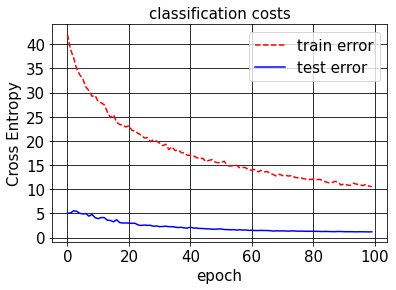

<Figure size 432x288 with 0 Axes>

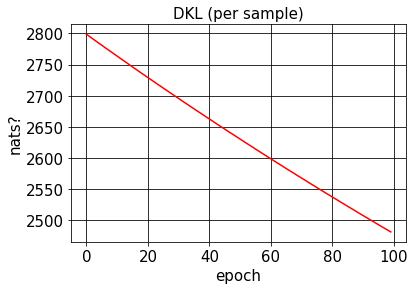

<Figure size 600x400 with 0 Axes>

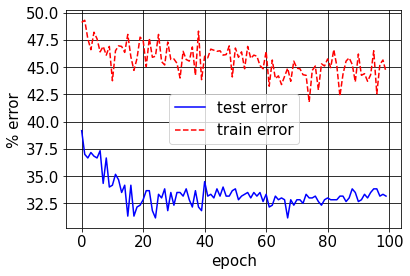

In [10]:

textsize = 15
marker = 5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(pred_cost_train, 'r--')
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['train error', 'test error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/pred_cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(kl_cost_train, 'r')
ax1.set_ylabel('nats?')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax = plt.gca()
plt.title('DKL (per sample)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/KL_cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.plot(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.plot(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png', bbox_extra_artists=(lgd,), box_inches='tight')


<Figure size 600x400 with 0 Axes>

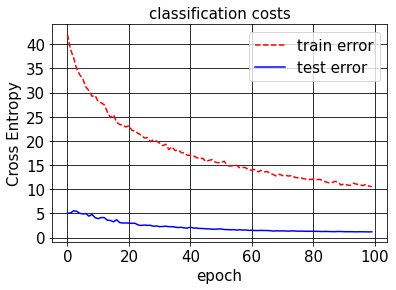

<Figure size 432x288 with 0 Axes>

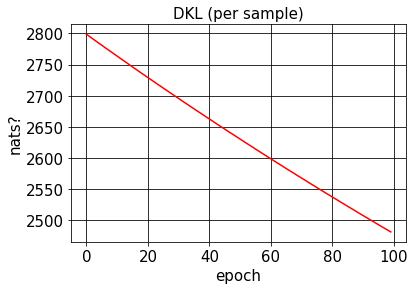

<Figure size 600x400 with 0 Axes>

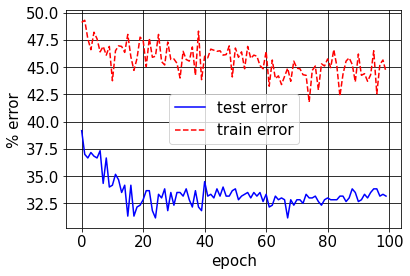

In [11]:
textsize = 15
marker = 5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(pred_cost_train, 'r--')
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['train error', 'test error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')


plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(kl_cost_train, 'r')
ax1.set_ylabel('nats?')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax = plt.gca()
plt.title('DKL (per sample)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')


plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.plot(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.plot(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')

plt.show()

# predict

In [12]:
trainset = torchvision.datasets.ImageFolder(root="./notebooks/data/COVID/train", transform=transform_covid19)
valset = torchvision.datasets.ImageFolder(root="./notebooks/data/COVID/test", transform=transform_covid19)

train_data_len = len(trainset.targets)
test_data_len = len(valset.targets)
use_cuda = torch.cuda.is_available()
NTrainPoints = train_data_len

#     # Where to save models weights
#     models_dir = args.models_dir
#     # Where to save plots and error, accuracy vectors
#     results_dir = args.results_dir


# ------------------------------------------------------------------------------------------------------
# train config


log_interval = 1

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')


if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=num_workers)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=num_workers)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


#nsamples = int(args.n_samples)  # How many samples to estimate ELBO with at each iteration
########################################################################################

if model == 'Local_Reparam':
    net = BBP_Bayes_Net_LR(lr=lr, channels_in=channels_in, side_in=image_trans_size, cuda=use_cuda, classes=classes,
                           batch_size=batch_size,
                           Nbatches=(NTrainPoints / batch_size), nhid=nhid, prior_sig=prior_sig)
elif model == 'Laplace_prior':
    net = BBP_Bayes_Net(lr=lr, channels_in=channels_in, side_in=image_trans_size, cuda=use_cuda, classes=classes,
                        batch_size=batch_size,
                        Nbatches=(NTrainPoints / batch_size), nhid=nhid,
                        prior_instance=laplace_prior(mu=0, b=prior_sig))
elif model == 'Gaussian_prior':
    net = BBP_Bayes_Net(lr=lr, channels_in=channels_in, side_in=image_trans_size, cuda=use_cuda, classes=classes,
                        batch_size=batch_size,
                        Nbatches=(NTrainPoints / batch_size), nhid=nhid,
                        prior_instance=isotropic_gauss_prior(mu=0, sigma=prior_sig))
elif model == 'GMM_prior':
    net = BBP_Bayes_Net(lr=lr, channels_in=channels_in, side_in=image_trans_size, cuda=use_cuda, classes=classes,
                        batch_size=batch_size,
                        Nbatches=(NTrainPoints / batch_size), nhid=nhid,
                        prior_instance=spike_slab_2GMM(mu1=0, mu2=0, sigma1=prior_sig, sigma2=0.0005, pi=0.75))
else:
    print('Invalid model type')
    exit(1)



savemodel_its = [20, 50, 80, 100]
save_dicts = []

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


########################################################################################


net.load(models_dir+'/theta_last.dat')  # theta_last.dat


test_cost = 0  # Note that these are per sample
test_err = 0
nb_samples = 0
test_predictions = np.zeros((test_data_len, 2))



net.set_mode_train(False)

for j, (x, y) in enumerate(valloader):
    cost, err, probs = net.sample_eval(x, y, Nsamples, logits=False) # , logits=True

    test_cost += cost
    test_err += err.cpu().numpy()
    test_predictions[nb_samples:nb_samples+len(x), :] = probs.numpy()
    nb_samples += len(x)

# test_cost /= nb_samples
test_err /= nb_samples
cprint('b', '    Loglike = %5.6f, err = %1.6f\n' % (-test_cost, test_err))



Data:

Network:

Net:
 Creating Net!! 
    Total params: 42.21M

Data:

Network:
Reading models_BBB_COVID150/theta_last.dat



C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_948/2671600186.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


  restoring epoch: 99, lr: 0.000010
    Loglike = -382.132141, err = 0.358333



In [13]:

x_dev = []
y_dev = []
for x, y in valloader:
    x_dev.append(x.cpu().numpy())
    y_dev.append(y.cpu().numpy())

x_dev = np.concatenate(x_dev)
y_dev = np.concatenate(y_dev)
print(x_dev.shape)
print(y_dev.shape)

im_ind = np.random.randint(0, y_dev.shape[0])
#im_ind = 73

print("image number:", im_ind)


x, y = x_dev[im_ind], y_dev[im_ind]
#x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], 0, reshape=False, cval=-0.42421296), 0)

print("real number:",y)

#plt.imshow( ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))

(600, 1, 128, 128)
(600,)
image number: 168
real number: 0


In [14]:
ims=[]


#ims.append(x_rot[:,:,:])
ims.append(x)

#ims = np.concatenate(ims)

net.set_mode_train(False)
y = np.ones(np.shape(ims)[0])*y
#y = np.ones(ims.shape[0])*y
#ims = np.expand_dims(ims, axis=1)
ims = np.array(ims)

cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, logits=False) # , logits=True

predictions = probs.numpy()

print("predictions", predictions)

print("error", err.cpu().numpy())


# predictions.max(axis=1)[0]
# selections = (predictions[:,i] == predictions.max(axis=1))
print("predict", predictions.argmax())

im_ind = np.random.randint(0, y_dev.shape[0])
print(im_ind)

print(valset[im_ind][1])

print(valset.class_to_idx)




predictions [[0.5924365  0.40756354]]
error 0
predict 0
141
0
{'0noncovid': 0, '1covid': 1}


# predict train

In [15]:
torch.cuda.empty_cache()

In [16]:
x_train_dev = []
y_train_dev = []
for x, y in trainloader:
    x_train_dev.append(x.cpu().numpy())
    y_train_dev.append(y.cpu().numpy())

x_train_dev = np.concatenate(x_train_dev)
y_train_dev = np.concatenate(y_train_dev)

In [17]:
y_true = []
y_pred = []
prob = []
for i in range(0,train_data_len):
    x, y = x_train_dev[i], y_train_dev[i]
    #x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], 0, reshape=False, cval=-0.42421296), 0)
    #print("real number:",y)
    y_true.append(y)
    #plt.imshow( ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))
    #plt.show()
    ims=[]
    #ims.append(x_rot[:,:,:])
    ims.append(x)
    #ims = np.concatenate(ims)
    net.set_mode_train(False)
    #y = np.ones(ims.shape[0])*y
    y = np.ones(np.shape(ims)[0])*y
    ims = np.array(ims)
    #ims = np.expand_dims(ims, axis=1)
    cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, logits=False) # , logits=True
    predictions = probs.numpy()
    prob.append(predictions)
#     print("predictions", predictions)
#     print("error", err.cpu().numpy())
    y_pred.append(predictions.argmax())
    torch.cuda.empty_cache()

print(y_pred)

prob = np.array(prob)
prob = prob.reshape(train_data_len, classes)

if save_data == True:
    save_path = 'BBB_predict_data'
    mkdir(save_path)
    file_name = "BBB_train_epochs=%d_lr=%f_batch_size=%d_image_trans_size=%d.csv" \
                % (nb_epochs, lr, batch_size, image_trans_size)
    completeName = os.path.join(save_path, file_name)
    print('c', completeName)
    if os.path.exists(completeName):
        os.remove(completeName)
    # df = pd.DataFrame(prob)
    # df.to_csv(completeName)
    np.savetxt(completeName, prob, delimiter=",")

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 

# predict test

In [18]:
torch.cuda.empty_cache()

In [19]:
y_true = []
y_pred = []
prob = []
for i in range(0,test_data_len):
    x, y = x_dev[i], y_dev[i]
    #x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], 0, reshape=False, cval=-0.42421296), 0)
    #print("real number:",y)
    y_true.append(y)
    #plt.imshow( ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))
    #plt.show()
    ims=[]
    #ims.append(x_rot[:,:,:])
    ims.append(x)
    #ims = np.concatenate(ims)
    net.set_mode_train(False)
    #y = np.ones(ims.shape[0])*y
    y = np.ones(np.shape(ims)[0])*y
    ims = np.array(ims)
    #ims = np.expand_dims(ims, axis=1)
    cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, logits=False) # , logits=True
    predictions = probs.numpy()
    prob.append(predictions)
#     print("predictions", predictions)
#     print("error", err.cpu().numpy())
    y_pred.append(predictions.argmax())
    torch.cuda.empty_cache()

print(y_pred)

prob = np.array(prob)
prob = prob.reshape(test_data_len, classes)

if save_data == True:
    save_path = 'BBB_predict_data'
    mkdir(save_path)
    file_name = "BBB_epochs=%d_lr=%f_batch_size=%d_image_trans_size=%d.csv" \
                % (nb_epochs, lr, batch_size, image_trans_size)
    completeName = os.path.join(save_path, file_name)
    print('c', completeName)
    if os.path.exists(completeName):
        os.remove(completeName)
    # df = pd.DataFrame(prob)
    # df.to_csv(completeName)
    np.savetxt(completeName, prob, delimiter=",")

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 